In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from tqdm import tqdm
import scanpy as sc

from figurefirst import FigureLayout,mpl_functions
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
from pathlib import Path
import sys
import warnings

from scgpt.model import TransformerModel
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.utils import set_seed
from scgpt.tokenizer import tokenize_and_pad_batch

# Suppress warnings
os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
set_seed(42)
import json

/home/gorilla/An/arunavanag/lib/python3.10/site-packages/scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/home/gorilla/An/arunavanag/lib/python3.10/site-packages/scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "../scgpt/best_model.pt"
vocab_path = "../scgpt/vocab.json"
args_path = "../scgpt/args.json"

pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]

# Load vocabulary
vocab = GeneVocab.from_file(vocab_path)
for s in special_tokens:
    if s not in vocab:
        vocab.append_token(s)

# Load model configurations from args.json
with open(args_path, "r") as f:
    model_configs = json.load(f)

print(f"Loading model from {model_path}, using config from {args_path}")

# Extract model parameters
embsize = model_configs["embsize"]
nhead = model_configs["nheads"]
d_hid = model_configs["d_hid"]
nlayers = model_configs["nlayers"]
n_layers_cls = model_configs.get("n_layers_cls", 1)  # Default to 1 if not specified
pad_value = -2  # As specified in the tutorial
n_input_bins = 51  # Number of input bins (can be adjusted based on your data)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ntokens = len(vocab)
model = TransformerModel(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    vocab=vocab,
    pad_value=pad_value,
    n_input_bins=n_input_bins,
    use_fast_transformer=True,  # Use fast transformer if available
)

try:
    model.load_state_dict(torch.load(model_path, map_location=device))
    print(f"Loaded all model parameters from {model_path}")
except:
    # Fallback: Load only matching parameters
    model_dict = model.state_dict()
    pretrained_dict = torch.load(model_path, map_location=device)
    pretrained_dict = {
        k: v
        for k, v in pretrained_dict.items()
        if k in model_dict and v.shape == model_dict[k].shape
    }
    for k, v in pretrained_dict.items():
        print(f"Loading parameter {k} with shape {v.shape}")
    
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)
    print("Loaded matching model parameters with partial fallback.")

# Move model to the appropriate device
model.to(device)
model.eval()

print("Model ready for inference or fine-tuning!")


Loading model from ../scgpt/best_model.pt, using config from ../scgpt/args.json
Loading parameter encoder.embedding.weight with shape torch.Size([60697, 512])
Loading parameter encoder.enc_norm.weight with shape torch.Size([512])
Loading parameter encoder.enc_norm.bias with shape torch.Size([512])
Loading parameter value_encoder.linear1.weight with shape torch.Size([512, 1])
Loading parameter value_encoder.linear1.bias with shape torch.Size([512])
Loading parameter value_encoder.linear2.weight with shape torch.Size([512, 512])
Loading parameter value_encoder.linear2.bias with shape torch.Size([512])
Loading parameter value_encoder.norm.weight with shape torch.Size([512])
Loading parameter value_encoder.norm.bias with shape torch.Size([512])
Loading parameter transformer_encoder.layers.0.self_attn.out_proj.weight with shape torch.Size([512, 512])
Loading parameter transformer_encoder.layers.0.self_attn.out_proj.bias with shape torch.Size([512])
Loading parameter transformer_encoder.laye

In [3]:
df = pd.read_hdf('../merged.h5')
df.rename(columns={'orig.ident': 'cartid'}, inplace=True)
response_mapping = {
    'notresponding': 0,
    'partialresponse': 1,
    'completeresponse': 2
}
df['encoded_response'] = df['response'].map(response_mapping)
df = df[df['percent.mt'] < 8]  # Less than 5% mitochondrial genes -> because more mitcondrial content shows stressed or dieing cell - chose 8 to avoid skewness in the data
df.reset_index(inplace=True, drop=True)
## Normalization
df.iloc[:, 1:-12]=df.iloc[:, 1:-12].div(df['nCount_RNA'], axis=0) * 1e4

df_convert = df.iloc[:, 1:-12].astype(float)
remaining_columns = pd.concat([df.iloc[:, :1], df.iloc[:, -12:]], axis=1)

# Concatenate the unconverted columns with df_converted
final_df = pd.concat([remaining_columns, df_convert], axis=1)
final_df.iloc[:, 13:] =final_df.iloc[:, 13:].apply(np.log1p)

adata = sc.AnnData(final_df.iloc[:, 13:])  # Gene columns are in these indices
metadata_columns = final_df.iloc[:, :13] 
## visualizing highly variable genes

sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
highly_variable_genes = adata.var[adata.var['highly_variable']].index
final_df = final_df.loc[:, final_df.columns.isin(highly_variable_genes)]
new_df = pd.concat([metadata_columns, final_df], axis=1)

In [4]:
all_counts = final_df.values
genes=highly_variable_genes.tolist()
gene_ids = np.array(vocab(genes), dtype=int)


batch_size = 16
tokenized_all = tokenize_and_pad_batch(
    all_counts,
    gene_ids,
    max_len=len(genes)+1,
    vocab=vocab,
    pad_token=pad_token,
    pad_value=pad_value,
    append_cls=True,  # append <cls> token at the beginning
    include_zero_gene=True,
)
# Extract gene IDs and expression values from the tokenized output
all_gene_ids, all_values = tokenized_all["genes"], tokenized_all["values"]

# Verify shapes
device = next(model.parameters()).device

# Convert to torch tensors and move to the appropriate device
all_gene_ids = torch.tensor(all_gene_ids, dtype=torch.long).to(device)
all_values = torch.tensor(all_values, dtype=torch.float).to(device)

In [ ]:
# num_splits = 5

# # Calculate the split size
# num_genes = all_gene_ids.size(1)
# split_size = num_genes // num_splits

# # Ensure the model is in evaluation mode
# model.eval()

# # Initialize a list to store final embeddings
# final_embeddings_list = []

# # Loop over each gene subset
# for split_idx in range(num_splits):
#     print(f"Processing split {split_idx + 1}/{num_splits}...")

#     # Define the gene range for the current split
#     start_idx = split_idx * split_size
#     end_idx = (split_idx + 1) * split_size if split_idx < num_splits - 1 else num_genes

#     # Extract the subset of gene IDs and values
#     split_gene_ids = all_gene_ids[:, start_idx:end_idx]
#     split_values = all_values[:, start_idx:end_idx]

#     # Initialize a list to store embeddings for the current split
#     split_embeddings_list = []

#     with torch.no_grad():
#         N = split_gene_ids.size(0)
#         batch_size = 8  # Small batch size to manage GPU memory
#         device = next(model.parameters()).device

#         for i in tqdm(range(0, N, batch_size)):
#             torch.cuda.empty_cache()

#             batch_gene_ids = split_gene_ids[i : i + batch_size].to(device)
#             batch_values = split_values[i : i + batch_size].to(device)

#             # Forward pass through the model
#             src_embs = model.encoder(batch_gene_ids)
#             val_embs = model.value_encoder(batch_values)
#             total_embs = src_embs + val_embs

#             # Pass through attention layers
#             for layer in model.transformer_encoder.layers[:11]:
#                 total_embs = layer(total_embs)

#             # Aggregate embeddings by averaging across the sequence (genes)
#             cell_embeddings = total_embs.mean(dim=1)
#             split_embeddings_list.append(cell_embeddings.cpu().numpy())

#             # Delete tensors to free memory
#             del batch_gene_ids, batch_values, src_embs, val_embs, total_embs
#             torch.cuda.empty_cache()

#     # Concatenate embeddings for the current split
#     split_embeddings = np.vstack(split_embeddings_list)
#     final_embeddings_list.append(split_embeddings)

# # Combine all splits to form the final embeddings
# final_embeddings = np.hstack(final_embeddings_list)

# print(f"Shape of final embeddings: {final_embeddings.shape}")  # Should be (num_cells, total_embedding_dim)


Processing split 1/5...


100%|██████████| 1933/1933 [00:23<00:00, 83.36it/s]


Processing split 2/5...


100%|██████████| 1933/1933 [00:23<00:00, 83.70it/s]


Processing split 3/5...


100%|██████████| 1933/1933 [00:23<00:00, 83.42it/s]


Processing split 4/5...


100%|██████████| 1933/1933 [00:23<00:00, 83.49it/s]


Processing split 5/5...


100%|██████████| 1933/1933 [00:23<00:00, 83.17it/s]


Shape of final embeddings: (15457, 2560)


In [5]:
cell_embeddings=np.load('../cell_embeddings.npy')

In [6]:
X = torch.tensor(cell_embeddings, dtype=torch.float32)
y = torch.tensor(df['encoded_response'].values, dtype=torch.long)

X_combined = np.hstack([X.to('cpu').numpy(), new_df.iloc[:, 13:].values])

# Convert to tensors
X_combined_t = torch.tensor(X_combined, dtype=torch.float32)
y_combined_t = torch.tensor(new_df['encoded_response'].values, dtype=torch.long)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_combined_t, y_combined_t, test_size=0.2, random_state=42)

# Update num_features for the new combined input
num_features = X_train.shape[1]
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [10]:
class SimpleCNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleCNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

def train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=50, loss_threshold=0.05):
    model.train()
    for epoch in range(num_epochs):
        for data, target in train_loader:
            # Move data and target to the same device as the model
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            # Early stopping condition based on the loss threshold
            if loss.item() < loss_threshold:
                print(f'Stopping training at Epoch {epoch+1}, Batch Loss: {loss.item()}')
                return  # Exit the training function early
        scheduler.step()
        print(f'Epoch {epoch+1}, Last Batch Loss: {loss.item()}')


num_features = X_train.shape[1]  # Number of features based on scGPT embeddings
num_classes = len(torch.unique(y_train))  # Number of unique classes

model_cnn = SimpleCNN(num_features, num_classes).to(device)
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.CrossEntropyLoss()

# Train the model
train_model(model_cnn, train_loader, criterion, optimizer, scheduler, num_epochs=50, loss_threshold=0.01)


Epoch 1, Last Batch Loss: 0.5862540602684021
Epoch 2, Last Batch Loss: 0.4143810272216797
Epoch 3, Last Batch Loss: 0.7063551545143127
Epoch 4, Last Batch Loss: 0.6628642678260803
Epoch 5, Last Batch Loss: 0.4802343249320984
Epoch 6, Last Batch Loss: 0.700219452381134
Epoch 7, Last Batch Loss: 0.23621122539043427
Epoch 8, Last Batch Loss: 0.038307081907987595
Epoch 9, Last Batch Loss: 0.18277110159397125
Epoch 10, Last Batch Loss: 0.33152225613594055
Epoch 11, Last Batch Loss: 0.5569728016853333
Epoch 12, Last Batch Loss: 0.20895172655582428
Epoch 13, Last Batch Loss: 0.11376027017831802
Epoch 14, Last Batch Loss: 0.028754455968737602
Epoch 15, Last Batch Loss: 0.01558132003992796
Stopping training at Epoch 16, Batch Loss: 0.009246171452105045


In [11]:
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            # Move data and target to the same device as the model
            data, target = data.to(device), target.to(device)

            # Forward pass
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)

            # Update total and correct counts
            total += target.size(0)
            correct += (predicted == target).sum().item()

    # Print the accuracy
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')

# Call the function with the appropriate device
evaluate_model(model_cnn, test_loader, device)


Accuracy: 80.43%


Generating ROC data: 100%|██████████| 49/49 [00:00<00:00, 961.80it/s]


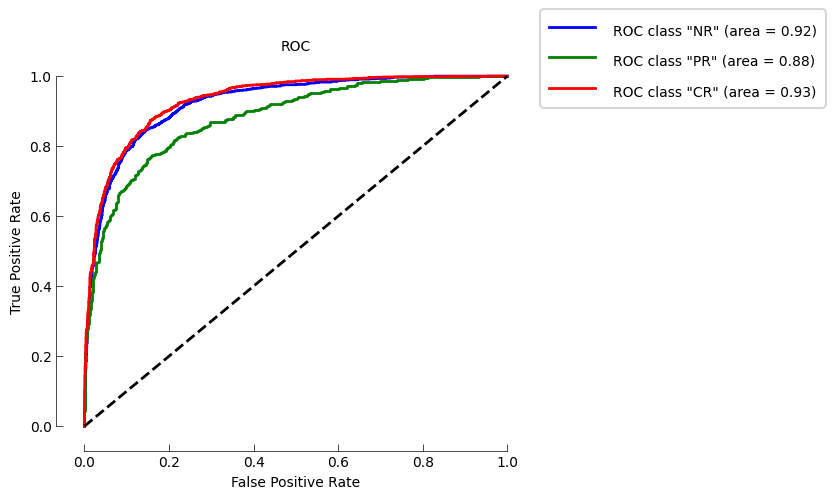

In [13]:

def plot_multiclass_roc(model, test_loader, num_classes, class_names, device):
    model.eval()
    y_scores, y_true = [], []

    # Collect predictions and true labels
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc="Generating ROC data"):
            # Move data and target to the same device as the model
            data, target = data.to(device), target.to(device)

            # Get model outputs and apply softmax for probabilities
            outputs = model(data)
            probabilities = torch.softmax(outputs, dim=1)
            y_scores.append(probabilities.cpu().numpy())
            y_true.append(target.cpu().numpy())

    # Convert lists to numpy arrays for further processing
    y_scores = np.vstack(y_scores)
    y_true = np.concatenate(y_true)

    # Binarize the labels for all classes
    y_true_bin = label_binarize(y_true, classes=range(num_classes))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    f, ax = plt.subplots(1, 1, figsize=(6, 5))
    colors = cycle(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black'])
    cn=["NR","PR","CR"]
    for i, color in zip(range(num_classes), colors):
        ax.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC class "{0}" (area = {1:0.2f})'.format(cn[i], roc_auc[i]))

    ax.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
    mpl_functions.adjust_spines(ax, ['left', 'bottom'], 
                                spine_locations={'left': 5, 'bottom': 5},
                                smart_bounds=True, 
                                xticks=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
                                yticks=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
                                linewidth=0.5)

    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC')
    ax.legend(loc='center left', bbox_to_anchor=(1, 1))
    mpl_functions.set_fontsize(f, 10)
    

    plt.show()


num_classes = 3
class_names = ["notresponding", "partialresponse", "completeresponse"]
plot_multiclass_roc(model_cnn, test_loader, num_classes, class_names, device)

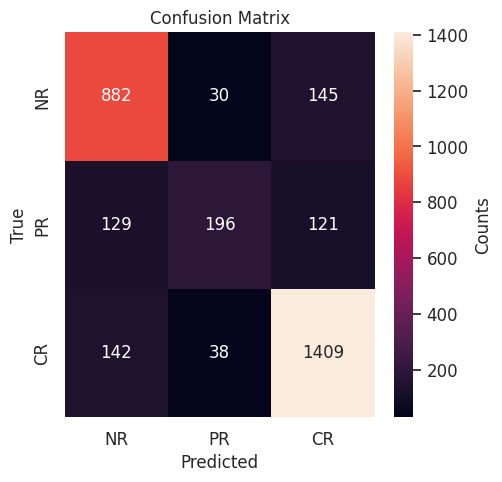

In [78]:
def evaluate_model(model, test_loader, class_names, device):
    y_pred, y_true = [], []
    model.eval()
    
    with torch.no_grad():
        for data, target in test_loader:
            # Move data and target to the same device as the model
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            _, preds = torch.max(output, 1)
            y_pred.extend(preds.cpu().tolist())
            y_true.extend(target.cpu().tolist())
    
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot the confusion matrix
    f, ax = plt.subplots(1, 1, figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d", cbar_kws={'label': 'Counts'}, 
                xticklabels=["NR","PR","CR"], yticklabels=["NR","PR","CR"], ax=ax)
    
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title('Confusion Matrix')
    
    # Customize font size if mpl_functions is available
    if 'mpl_functions' in globals():
        mpl_functions.set_fontsize(f, 12)
    
    plt.show()

# Example usage
class_names = ["notresponding", "partialresponse", "completeresponse"]
evaluate_model(model_cnn, test_loader, class_names, device)

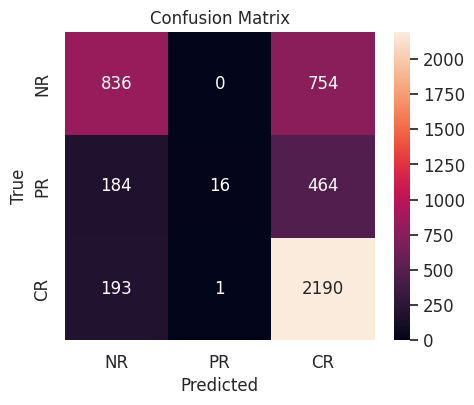

In [85]:
conf_matrix = np.array([
    [836, 0, 754],
    [184, 16, 464],
    [193, 1, 2190]
])

# Class labels
classes = ['NR', 'PR', 'CR']

# Create figure and axis
f, ax = plt.subplots(figsize=(5, 4))

# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d',  xticklabels=classes, yticklabels=classes, ax=ax)

# Add labels and title
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
mpl_functions.set_fontsize(f,12)

In [16]:
groups = df.groupby('response').groups
condition_ids = df['response'].values  # Assuming 'response' is the condition column
print(f"Unique conditions: {df['response'].unique()}")

Unique conditions: ['notresponding' 'partialresponse' 'completeresponse']


In [ ]:
# # Number of splits and batch size
# num_splits = 5
# batch_size = 8
# num_attn_layers = 11  # Number of attention layers to use

# # Calculate the split size
# num_genes = all_gene_ids.size(1)
# split_size = num_genes // num_splits
# max_genes = split_size + 1  # Allow for padding by 1 to handle uneven splits

# # Initialize dictionary to store attention weights for each condition
# dict_sum_condition = {}

# # Ensure the model is in evaluation mode
# model.eval()

# # Process the first 4 splits
# for split_idx in range(4):
#     print(f"Processing split {split_idx + 1}/{4}...")

#     # Define the gene range for the current split
#     start_idx = split_idx * split_size
#     end_idx = (split_idx + 1) * split_size

#     # Extract the subset of gene IDs and values
#     split_gene_ids = all_gene_ids[:, start_idx:end_idx]
#     split_values = all_values[:, start_idx:end_idx]

#     with torch.no_grad():
#         N = split_gene_ids.size(0)
#         device = next(model.parameters()).device

#         for i in tqdm(range(0, N, batch_size)):
#             torch.cuda.empty_cache()

#             batch_gene_ids = split_gene_ids[i : i + batch_size].to(device)
#             batch_values = split_values[i : i + batch_size].to(device)

#             # Forward pass through the model
#             src_embs = model.encoder(batch_gene_ids)
#             val_embs = model.value_encoder(batch_values)
#             total_embs = src_embs + val_embs

#             # Pass through attention layers
#             for layer in model.transformer_encoder.layers[:num_attn_layers]:
#                 total_embs = layer(total_embs)

#             # Extract attention weights from the 12th layer
#             attn_output, attn_weights = model.transformer_encoder.layers[num_attn_layers].self_attn(
#                 total_embs, total_embs, total_embs, need_weights=True
#             )

#             # Average across attention heads
#             attn_scores = attn_weights.mean(dim=1)  # Shape: (batch_size, num_genes_in_split, num_genes_in_split)

#             # Pad attention scores to max_genes
#             pad_size = max_genes - attn_scores.size(1)
#             attn_scores_padded = torch.nn.functional.pad(attn_scores, (0, pad_size, 0, pad_size))

#             # Store attention weights by condition
#             for index in range(batch_gene_ids.size(0)):
#                 condition = condition_ids[i : i + batch_size][index]
#                 if condition not in dict_sum_condition:
#                     dict_sum_condition[condition] = np.zeros((max_genes, max_genes), dtype=np.float32)
#                 dict_sum_condition[condition] += attn_scores_padded[index].cpu().numpy()

#             # Delete tensors to free memory
#             del batch_gene_ids, batch_values, src_embs, val_embs, total_embs, attn_scores, attn_output
#             torch.cuda.empty_cache()

# print("Processing for the first 4 splits complete.")
# # Process the last split manually with batch size 7



Processing split 1/4...


100%|██████████| 1933/1933 [00:27<00:00, 69.54it/s]


Processing split 2/4...


100%|██████████| 1933/1933 [00:27<00:00, 69.75it/s]


Processing split 3/4...


100%|██████████| 1933/1933 [00:27<00:00, 69.69it/s]


Processing split 4/4...


100%|██████████| 1933/1933 [00:27<00:00, 69.63it/s]

Processing for the first 4 splits complete.


In [ ]:
# # Calculate the start and end indices for the last split
# start_idx = (num_splits - 1) * split_size
# end_idx = num_genes  # The last index to cover all genes

# # Extract the subset of gene IDs and values for the last split
# final_split_gene_ids = all_gene_ids[:, start_idx:end_idx]
# final_split_values = all_values[:, start_idx:end_idx]

# # Check the number of samples (cells) in the final split
# num_samples_in_final_split = final_split_gene_ids.size(0)
# print(f"Number of samples in the final split: {num_samples_in_final_split}")

# last_batch_size = final_split_gene_ids[-13:].size(0)
# print(f"Last batch size: {last_batch_size}")



Number of samples in the final split: 15457
Last batch size: 13


In [ ]:
# # Set parameters
# batch_size = 13  # Batch size for the final split
# num_attn_layers = 11  # Number of attention layers to use
# device = next(model.parameters()).device

# # Ensure the model is in evaluation mode
# model.eval()

# # Debug: Check the number of samples in the final split
# N = final_split_gene_ids.size(0)
# print(f"Number of samples in the final split: {N}")

# # Initialize dict_sum_condition if not already initialized
# dict_sum_condition = {}

# with torch.no_grad():
#     for i in tqdm(range(0, N, batch_size)):
#         torch.cuda.empty_cache()

#         # Extract the current batch
#         batch_gene_ids = final_split_gene_ids[i : i + batch_size].to(device)
#         batch_values = final_split_values[i : i + batch_size].to(device)

#         # Forward pass through the model
#         src_embs = model.encoder(batch_gene_ids)
#         val_embs = model.value_encoder(batch_values)
#         total_embs = src_embs + val_embs

#         # Pass through attention layers
#         for layer in model.transformer_encoder.layers[:num_attn_layers]:
#             total_embs = layer(total_embs)

#         # Extract attention weights from the 12th layer
#         attn_output, attn_weights = model.transformer_encoder.layers[num_attn_layers].self_attn(
#             total_embs, total_embs, total_embs, need_weights=True
#         )

#         # Average across attention heads
#         attn_scores = attn_weights.mean(dim=1)  # Shape: (batch_size, num_genes, num_genes)

#         # Calculate padding size to ensure uniform dimensions
#         max_genes = attn_scores.size(1)
#         pad_size = max_genes - attn_scores.size(1)

#         # Pad attention scores if necessary
#         if pad_size > 0:
#             attn_scores_padded = torch.nn.functional.pad(attn_scores, (0, pad_size, 0, pad_size))
#         else:
#             attn_scores_padded = attn_scores

#         # Store attention weights by condition
#         for index in range(batch_gene_ids.size(0)):
#             condition = condition_ids[i : i + batch_size][index]
#             if condition not in dict_sum_condition:
#                 dict_sum_condition[condition] = np.zeros((max_genes, max_genes), dtype=np.float32)
#             dict_sum_condition[condition] += attn_scores_padded[index].cpu().numpy()

#         # Delete tensors to free memory
#         del batch_gene_ids, batch_values, src_embs, val_embs, total_embs, attn_scores, attn_output
#         torch.cuda.empty_cache()

# print("Final split processing complete.")

Number of samples in the final split: 15457


100%|██████████| 1189/1189 [00:27<00:00, 43.53it/s]

Final split processing complete.


In [ ]:
# np.savez("../attention_weights.npz", **dict_sum_condition)
dict_sum_condition=np.load('../attention_weights.npz')

array([[8.939318, 9.078021, 9.069478, ..., 9.006532, 9.086865, 9.0783  ],
       [8.939318, 9.078021, 9.069478, ..., 9.006532, 9.086865, 9.0783  ],
       [8.939318, 9.078021, 9.069478, ..., 9.006532, 9.086865, 9.0783  ],
       ...,
       [8.939318, 9.078021, 9.069478, ..., 9.006532, 9.086865, 9.0783  ],
       [8.939318, 9.078021, 9.069478, ..., 9.006532, 9.086865, 9.0783  ],
       [8.939318, 9.078021, 9.069478, ..., 9.006532, 9.086865, 9.0783  ]],
      dtype=float32)

In [35]:
dict_sum_condition_mean = dict_sum_condition.copy()

# Normalize by the number of cells in each condition
for condition in groups.keys():
    dict_sum_condition_mean[condition] = dict_sum_condition[condition] / len(groups[condition])

In [165]:
def get_topk_most_influenced_genes(dict_sum_condition_mean, gene_vocab_idx, vocab, topk=20, setting='difference', control_condition='notresponding'):
    attn_top_gene_dict = {}
    attn_top_scores_dict = {}

    # Ensure the control condition exists
    if control_condition not in dict_sum_condition_mean:
        raise ValueError(f"Control condition '{control_condition}' not found in dict_sum_condition_mean keys.")

    # Iterate through each condition in the dictionary
    for condition in dict_sum_condition_mean.keys():
        if condition != control_condition:  # Skip the control condition itself
            # Extract the knockout gene from the condition name
            knockout_gene = condition.split('+')[0]
            knockout_gene_idx = np.where(gene_vocab_idx == vocab([knockout_gene])[0])[0][0]

            # Get the control and experiment attention weights
            control = dict_sum_condition_mean[control_condition][:, knockout_gene_idx]
            exp = dict_sum_condition_mean[condition][:, knockout_gene_idx]

            # Compute the influence based on the selected setting
            if setting == 'difference':
                influence_scores = exp - control
            elif setting == 'control':
                influence_scores = control
            elif setting == 'perturbed':
                influence_scores = exp
            else:
                raise ValueError("Invalid setting. Choose from 'difference', 'control', or 'perturbed'.")

            # Select the top-k most influenced genes
            topk_indices = np.argpartition(influence_scores, -topk)[-topk:]
            topk_scores = influence_scores[topk_indices]
            topk_genes = vocab.lookup_tokens(gene_vocab_idx[topk_indices])

            # Store the results in dictionaries
            attn_top_gene_dict[condition] = topk_genes
            attn_top_scores_dict[condition] = topk_scores

    return attn_top_gene_dict, attn_top_scores_dict

# Assume dict_sum_condition_mean contains attention scores computed from the model
gene_vocab_idx = all_gene_ids[0].clone().detach().cpu().numpy()

# Parameters
topk = 20
setting = 'difference'  # Options: 'control', 'perturbed', or 'difference'
control_condition = 'notresponding'  # Use 'notresponding' as the control

# Get the top-k most influenced genes
attn_top_gene_dict, attn_top_scores_dict = get_topk_most_influenced_genes(
    dict_sum_condition_mean,
    gene_vocab_idx,
    vocab,
    topk=topk,
    setting=setting,
    control_condition=control_condition
)

# Example: Print results for a specific condition
# List of conditions to retrieve results for
example_conditions = ['completeresponse', 'partialresponse']

# Loop through each condition in the list
for condition in example_conditions:
    print(f"Top {topk} most influenced genes for {condition}:")
    print(attn_top_scores_dict[condition])
    print(attn_top_gene_dict[condition])
    print("-" * 50)  # Separator for readability



Top 20 most influenced genes for completeresponse:
[1.3702083e-07 1.3702083e-07 1.3702083e-07 1.3702083e-07 1.3702083e-07
 1.3702083e-07 1.3702083e-07 1.3702083e-07 1.3702083e-07 1.3702083e-07
 1.3702083e-07 1.3702083e-07 1.3702083e-07 1.3702083e-07 1.3702083e-07
 1.3702083e-07 1.3702083e-07 1.3702083e-07 1.3702083e-07 1.3702083e-07]
['CD84', 'F5', 'AIM2', 'TNFAIP8L2', 'ETV3', 'NTRK1', 'SH2D2A', 'TTC24', 'GLMP', 'LMNA', '<pad>', 'CKS1B', 'PYGO2', 'PBXIP1', 'ATP8B2', 'UBAP2L', 'S100A10', 'THEM4', 'RFX5', 'MGLL']
--------------------------------------------------
Top 20 most influenced genes for partialresponse:
[1.3725366e-07 1.3725366e-07 1.3725366e-07 1.3725366e-07 1.3725366e-07
 1.3725366e-07 1.3725366e-07 1.3725366e-07 1.3725366e-07 1.3725366e-07
 1.3725366e-07 1.3725366e-07 1.3725366e-07 1.3725366e-07 1.3725366e-07
 1.3725366e-07 1.3725366e-07 1.3725366e-07 1.3725366e-07 1.3725366e-07]
['CD84', 'F5', 'AIM2', 'TNFAIP8L2', 'ETV3', 'NTRK1', 'SH2D2A', 'TTC24', 'GLMP', 'LMNA', '<pad>', 

In [166]:
# Ensure we are only processing if setting is 'difference'
if setting == 'difference':
    # Dictionary to store DataFrames for different conditions
    df_scores_dict = {}

    for condition in attn_top_gene_dict.keys():
        example_genes = attn_top_gene_dict[condition]
        
        # Get the indices of the top-k genes
        gene_idx = [np.where(gene_vocab_idx == vocab([g])[0])[0][0] for g in example_genes]
        
        # Compute the scores for visualization (difference between condition and 'notresponding')
        scores = dict_sum_condition_mean[condition][gene_idx, :][:, gene_idx] - dict_sum_condition_mean['notresponding'][gene_idx, :][:, gene_idx]
        
        # Create a DataFrame for each condition
        df_scores = pd.DataFrame(data=scores, columns=example_genes, index=example_genes)
        
        # Store in the dictionary using the condition name
        df_scores_dict[condition] = df_scores

    # Create individual DataFrames for easy access
    df_scores_partial = df_scores_dict.get('partialresponse')
    df_scores_complete = df_scores_dict.get('completeresponse')


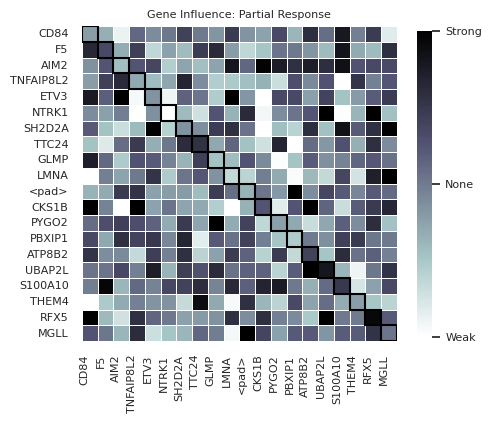

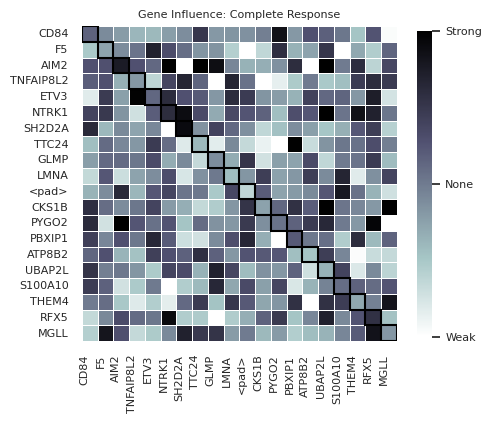

In [171]:
def plot_heatmap(df_scores, condition):
    # Optional: Add small noise for variability
    df_scores_perturbed = df_scores + np.random.normal(0, 1e-3, df_scores.shape)

    # Create a figure and axes
    f, ax = plt.subplots(1, 1, figsize=(5, 5))

    # Plot the heatmap
    heatmap = sns.heatmap(df_scores_perturbed, ax=ax, cmap='bone_r', vmin=-0.002, vmax=0.002, linewidths=0.5, square=True, cbar_kws={'shrink': 0.7})
    cbar = heatmap.collections[0].colorbar
    cbar.set_ticks([-0.002, 0, 0.002])
    cbar.set_ticklabels(['Weak', 'None', 'Strong'])
    # Add diagonal line for emphasis
    for i in range(df_scores.shape[0]):
        ax.add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='black', lw=1.5))

    # Set title and labels
    ax.set_title(f"Gene Influence: {condition}")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right", fontsize=8)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=8)
    mpl_functions.set_fontsize(f,8)
    # Adjust layout for better display
    f.tight_layout()
    

# Plot for partial response
if df_scores_partial is not None:
    plot_heatmap(df_scores_partial, "Partial Response")

# Plot for complete response
if df_scores_complete is not None:
    plot_heatmap(df_scores_complete, "Complete Response")


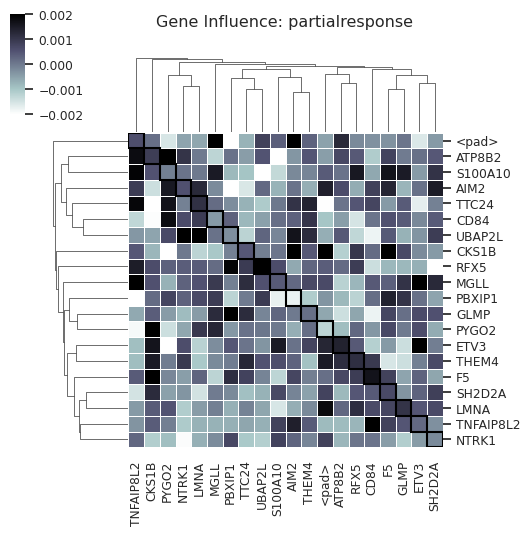

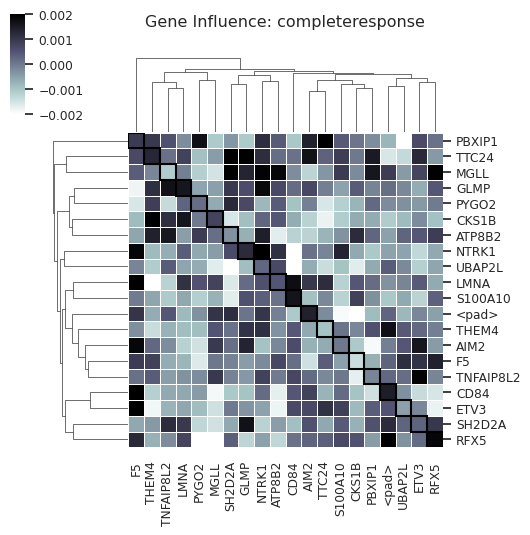

In [175]:
if setting == 'difference':
    for condition in attn_top_gene_dict.keys():
        example_genes = attn_top_gene_dict[condition]
        
        # Get the indices of the top-k genes
        gene_idx = [np.where(gene_vocab_idx == vocab([g])[0])[0][0] for g in example_genes]
        
        # Compute the scores for visualization (difference between condition and 'notresponding')
        scores = dict_sum_condition_mean[condition][gene_idx, :][:, gene_idx] - dict_sum_condition_mean['notresponding'][gene_idx, :][:, gene_idx]
        
        # Create a DataFrame for plotting
        df_scores = pd.DataFrame(data=scores, columns=example_genes, index=example_genes)
        
        # Add small noise to enhance variability (helps with flat plots)
        df_scores_perturbed = df_scores + np.random.normal(0, 1e-3, df_scores.shape)
        
        # Generate the clustermap
        g = sns.clustermap(
            df_scores_perturbed,
            annot=False,
            cmap='bone_r',
            vmin=-0.002,
            vmax=0.002,
            figsize=(5, 5),
            linewidths=0.5,  # Add lines between cells
            linecolor=None,  # Color of the lines between cells
            cbar_pos=(-0.05, 0.85, 0.03, 0.2)
        )
        # Get the heatmap axes
        ax = g.ax_heatmap
        for i in range(df_scores.shape[0]):
            ax.add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='black', lw=1.5))
        # g.fig.suptitle(f"Gene Influence Heatmap: {condition}", fontsize=16)

        plt.suptitle(f"Gene Influence: {condition}", y=1.05)
        # plt.tight_layout()


In [ ]:
# # Add small noise to enhance variability
# df_scores_perturbed = df_scores + np.random.normal(0, 1e-3, df_scores.shape)

# # Plot the clustermap with adjusted vmin and vmax
# plt.figure(figsize=(5, 5), dpi=300)
# sns.clustermap(
#     df_scores_perturbed,
#     annot=False,
#     cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True),  # Try a different palette
#     vmin=-0.002,  # Adjust based on the range of your data
#     vmax=0.002
# )
# plt.title(f"Gene Influence Heatmap: {condition}")

